In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sampleSubmission.csv', 'test1', 'train']


In [2]:
os.listdir("../")

['dogs_vs_cats.jpg', 'input', 'notebooks', 'test', 'train']

In [3]:
# if not os.path.exists("../train"):
#     os.mkdir("../train")
# if not os.path.exists("../train/dog"):
#     os.mkdir("../train/dog")
# if not os.path.exists("../train/cat"):
#     os.mkdir("../train/cat")

In [4]:
import shutil
from tqdm import tqdm

In [5]:
for i in tqdm(os.listdir("../input/train")):
#     print(i)
    if i.split(".")[0] == "dog":
        shutil.copy2(os.path.join("../input/train",i),os.path.join("../train/dog",i))
    elif i.split(".")[0] == "cat":
        shutil.copy2(os.path.join("../input/train",i),os.path.join("../train/cat",i))
        

100%|██████████| 25000/25000 [00:46<00:00, 537.08it/s] 


In [6]:
# if not os.path.exists("../test"):
#     os.mkdir("../test")
# if not os.path.exists("../test/dog"):
#     os.mkdir("../test/dog")
# if not os.path.exists("../test/cat"):
#     os.mkdir("../test/cat")

In [7]:
for i in tqdm(os.listdir("../train/dog")[:3000]):
    shutil.move(os.path.join("../train/dog",i),os.path.join("../test/dog",i)) 
for i in tqdm(os.listdir("../train/cat")[:3000]):
    shutil.move(os.path.join("../train/cat",i),os.path.join("../test/cat",i)) 

100%|██████████| 3000/3000 [00:40<00:00, 73.20it/s] 


In [8]:
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

Using TensorFlow backend.


In [9]:
keras.__version__

'2.3.1'

In [10]:
import tensorflow
tensorflow.__version__

'2.0.0'

In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7234701800882856992,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4854028697
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14256308399957734462
 physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [12]:
os.listdir("../train")

['cat', 'dog']

In [13]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="../train",target_size=(224,224))

Found 19000 images belonging to 2 classes.


In [14]:
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="../test", target_size=(224,224))

Found 6000 images belonging to 2 classes.


In [15]:
from keras.applications.vgg16 import VGG16

In [16]:
vggmodel = VGG16(weights='imagenet', include_top=True)

In [17]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [19]:
X= vggmodel.layers[-2].output

In [20]:
predictions = Dense(2, activation="softmax")(X)

In [21]:
model_final = Model(input = vggmodel.input, output = predictions)

C:\Users\iiats\Anaconda3\envs\Python 3_7-gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [22]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [23]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [25]:
os.listdir("../")

['dogs_vs_cats.jpg', 'input', 'notebooks', 'test', 'train']

In [26]:
checkpoint = ModelCheckpoint(
    "vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')


In [27]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 5, epochs= 100, 
                                 validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])

Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 1.0466 - accuracy: 0.6125 - val_loss: 0.3348 - val_accuracy: 0.8750

Epoch 00001: val_accuracy improved from -inf to 0.87500, saving model to vgg16_1.h5
Epoch 2/100
5/5 [==============================] - 1s 197ms/step - loss: 0.2449 - accuracy: 0.8875 - val_loss: 0.1613 - val_accuracy: 0.9062

Epoch 00002: val_accuracy improved from 0.87500 to 0.90625, saving model to vgg16_1.h5
Epoch 3/100
5/5 [==============================] - 1s 196ms/step - loss: 0.1431 - accuracy: 0.9312 - val_loss: 0.0972 - val_accuracy: 0.9375

Epoch 00003: val_accuracy improved from 0.90625 to 0.93750, saving model to vgg16_1.h5
Epoch 4/100
5/5 [==============================] - 1s 198ms/step - loss: 0.1559 - accuracy: 0.9500 - val_loss: 0.0568 - val_accuracy: 0.9375

Epoch 00004: val_accuracy did not improve from 0.93750
Epoch 5/100
5/5 [==============================] - 1s 194ms/step - loss: 0.2231 - accuracy: 0.9438 - val_loss: 0.1217 - va

5/5 [==============================] - 1s 196ms/step - loss: 0.0953 - accuracy: 0.9563 - val_loss: 0.1367 - val_accuracy: 0.9375

Epoch 00042: val_accuracy did not improve from 1.00000
Epoch 43/100
5/5 [==============================] - 1s 195ms/step - loss: 0.0284 - accuracy: 0.9875 - val_loss: 0.0454 - val_accuracy: 0.9688

Epoch 00043: val_accuracy did not improve from 1.00000
Epoch 44/100
5/5 [==============================] - 1s 196ms/step - loss: 0.0495 - accuracy: 0.9812 - val_loss: 0.0143 - val_accuracy: 1.0000

Epoch 00044: val_accuracy did not improve from 1.00000
Epoch 45/100
5/5 [==============================] - 1s 196ms/step - loss: 0.0992 - accuracy: 0.9625 - val_loss: 0.1227 - val_accuracy: 0.9375

Epoch 00045: val_accuracy did not improve from 1.00000
Epoch 46/100
5/5 [==============================] - 1s 196ms/step - loss: 0.1144 - accuracy: 0.9688 - val_loss: 0.0147 - val_accuracy: 1.0000

Epoch 00046: val_accuracy did not improve from 1.00000
Epoch 47/100
5/5 [=====

In [31]:
# 学習プロセスのプロット用関数

def Learning_Process_Plot(history):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc', ls="-", marker="o")
    plt.plot(epochs, val_acc, label='Validation acc', ls="-", marker="x")
    plt.title('Training and validation accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.figure()

    plt.plot(epochs, loss, label='Training loss', ls="-", marker="o")
    plt.plot(epochs, val_loss, label='Validation loss', ls="-", marker="x")
    plt.title('Training and validation loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.show()

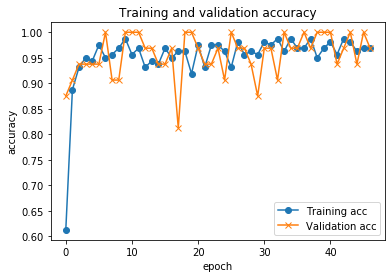

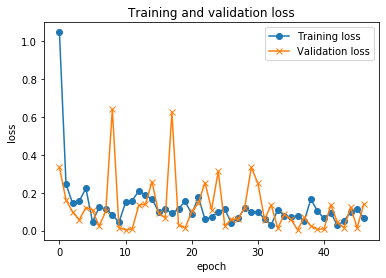

In [32]:
# 学習プロセスのプロット
Learning_Process_Plot(hist)

In [33]:
model_final.save_weights("vgg16_1.h5")

In [31]:
import pandas as pd
df=pd.read_csv("../input/sampleSubmission.csv")

In [32]:
print(df["label"][0])
pd.options.mode.chained_assignment = None  # default='warn'

0


In [33]:
for e,i in enumerate(os.listdir("../input/test1")):
    print(i)
    output=[]
    img = image.load_img(os.path.join("../input/test1",i),target_size=(224,224))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = model_final.predict(img)
    if output[0][0] > output[0][1]:
#         print("cat")
        df["id"][e]=i
        df["label"][e]="cat"
    else:
#         print('dog')
        df["id"][e]=i
        df["label"][e]="dog"

1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
1001.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg
10019.jpg
1002.jpg
10020.jpg
10021.jpg
10022.jpg
10023.jpg
10024.jpg
10025.jpg
10026.jpg
10027.jpg
10028.jpg
10029.jpg
1003.jpg
10030.jpg
10031.jpg
10032.jpg
10033.jpg
10034.jpg
10035.jpg
10036.jpg
10037.jpg
10038.jpg
10039.jpg
1004.jpg
10040.jpg
10041.jpg
10042.jpg
10043.jpg
10044.jpg
10045.jpg
10046.jpg
10047.jpg
10048.jpg
10049.jpg
1005.jpg
10050.jpg
10051.jpg
10052.jpg
10053.jpg
10054.jpg
10055.jpg
10056.jpg
10057.jpg
10058.jpg
10059.jpg
1006.jpg
10060.jpg
10061.jpg
10062.jpg
10063.jpg
10064.jpg
10065.jpg
10066.jpg
10067.jpg
10068.jpg
10069.jpg
1007.jpg
10070.jpg
10071.jpg
10072.jpg
10073.jpg
10074.jpg
10075.jpg
10076.jpg
10077.jpg
10078.jpg
10079.jpg
1008.jpg
10080.jpg
10081.jpg
10082.jpg
10083.jpg
10084.jpg
10085.jpg
10086.jpg
10087.jpg
10088.jpg
10089.jp

10750.jpg
10751.jpg
10752.jpg
10753.jpg
10754.jpg
10755.jpg
10756.jpg
10757.jpg
10758.jpg
10759.jpg
1076.jpg
10760.jpg
10761.jpg
10762.jpg
10763.jpg
10764.jpg
10765.jpg
10766.jpg
10767.jpg
10768.jpg
10769.jpg
1077.jpg
10770.jpg
10771.jpg
10772.jpg
10773.jpg
10774.jpg
10775.jpg
10776.jpg
10777.jpg
10778.jpg
10779.jpg
1078.jpg
10780.jpg
10781.jpg
10782.jpg
10783.jpg
10784.jpg
10785.jpg
10786.jpg
10787.jpg
10788.jpg
10789.jpg
1079.jpg
10790.jpg
10791.jpg
10792.jpg
10793.jpg
10794.jpg
10795.jpg
10796.jpg
10797.jpg
10798.jpg
10799.jpg
108.jpg
1080.jpg
10800.jpg
10801.jpg
10802.jpg
10803.jpg
10804.jpg
10805.jpg
10806.jpg
10807.jpg
10808.jpg
10809.jpg
1081.jpg
10810.jpg
10811.jpg
10812.jpg
10813.jpg
10814.jpg
10815.jpg
10816.jpg
10817.jpg
10818.jpg
10819.jpg
1082.jpg
10820.jpg
10821.jpg
10822.jpg
10823.jpg
10824.jpg
10825.jpg
10826.jpg
10827.jpg
10828.jpg
10829.jpg
1083.jpg
10830.jpg
10831.jpg
10832.jpg
10833.jpg
10834.jpg
10835.jpg
10836.jpg
10837.jpg
10838.jpg
10839.jpg
1084.jpg
10840.jpg
1

11501.jpg
11502.jpg
11503.jpg
11504.jpg
11505.jpg
11506.jpg
11507.jpg
11508.jpg
11509.jpg
1151.jpg
11510.jpg
11511.jpg
11512.jpg
11513.jpg
11514.jpg
11515.jpg
11516.jpg
11517.jpg
11518.jpg
11519.jpg
1152.jpg
11520.jpg
11521.jpg
11522.jpg
11523.jpg
11524.jpg
11525.jpg
11526.jpg
11527.jpg
11528.jpg
11529.jpg
1153.jpg
11530.jpg
11531.jpg
11532.jpg
11533.jpg
11534.jpg
11535.jpg
11536.jpg
11537.jpg
11538.jpg
11539.jpg
1154.jpg
11540.jpg
11541.jpg
11542.jpg
11543.jpg
11544.jpg
11545.jpg
11546.jpg
11547.jpg
11548.jpg
11549.jpg
1155.jpg
11550.jpg
11551.jpg
11552.jpg
11553.jpg
11554.jpg
11555.jpg
11556.jpg
11557.jpg
11558.jpg
11559.jpg
1156.jpg
11560.jpg
11561.jpg
11562.jpg
11563.jpg
11564.jpg
11565.jpg
11566.jpg
11567.jpg
11568.jpg
11569.jpg
1157.jpg
11570.jpg
11571.jpg
11572.jpg
11573.jpg
11574.jpg
11575.jpg
11576.jpg
11577.jpg
11578.jpg
11579.jpg
1158.jpg
11580.jpg
11581.jpg
11582.jpg
11583.jpg
11584.jpg
11585.jpg
11586.jpg
11587.jpg
11588.jpg
11589.jpg
1159.jpg
11590.jpg
11591.jpg
11592.jpg

12252.jpg
12253.jpg
12254.jpg
12255.jpg
12256.jpg
12257.jpg
12258.jpg
12259.jpg
1226.jpg
12260.jpg
12261.jpg
12262.jpg
12263.jpg
12264.jpg
12265.jpg
12266.jpg
12267.jpg
12268.jpg
12269.jpg
1227.jpg
12270.jpg
12271.jpg
12272.jpg
12273.jpg
12274.jpg
12275.jpg
12276.jpg
12277.jpg
12278.jpg
12279.jpg
1228.jpg
12280.jpg
12281.jpg
12282.jpg
12283.jpg
12284.jpg
12285.jpg
12286.jpg
12287.jpg
12288.jpg
12289.jpg
1229.jpg
12290.jpg
12291.jpg
12292.jpg
12293.jpg
12294.jpg
12295.jpg
12296.jpg
12297.jpg
12298.jpg
12299.jpg
123.jpg
1230.jpg
12300.jpg
12301.jpg
12302.jpg
12303.jpg
12304.jpg
12305.jpg
12306.jpg
12307.jpg
12308.jpg
12309.jpg
1231.jpg
12310.jpg
12311.jpg
12312.jpg
12313.jpg
12314.jpg
12315.jpg
12316.jpg
12317.jpg
12318.jpg
12319.jpg
1232.jpg
12320.jpg
12321.jpg
12322.jpg
12323.jpg
12324.jpg
12325.jpg
12326.jpg
12327.jpg
12328.jpg
12329.jpg
1233.jpg
12330.jpg
12331.jpg
12332.jpg
12333.jpg
12334.jpg
12335.jpg
12336.jpg
12337.jpg
12338.jpg
12339.jpg
1234.jpg
12340.jpg
12341.jpg
12342.jpg
1

1806.jpg
1807.jpg
1808.jpg
1809.jpg
181.jpg
1810.jpg
1811.jpg
1812.jpg
1813.jpg
1814.jpg
1815.jpg
1816.jpg
1817.jpg
1818.jpg
1819.jpg
182.jpg
1820.jpg
1821.jpg
1822.jpg
1823.jpg
1824.jpg
1825.jpg
1826.jpg
1827.jpg
1828.jpg
1829.jpg
183.jpg
1830.jpg
1831.jpg
1832.jpg
1833.jpg
1834.jpg
1835.jpg
1836.jpg
1837.jpg
1838.jpg
1839.jpg
184.jpg
1840.jpg
1841.jpg
1842.jpg
1843.jpg
1844.jpg
1845.jpg
1846.jpg
1847.jpg
1848.jpg
1849.jpg
185.jpg
1850.jpg
1851.jpg
1852.jpg
1853.jpg
1854.jpg
1855.jpg
1856.jpg
1857.jpg
1858.jpg
1859.jpg
186.jpg
1860.jpg
1861.jpg
1862.jpg
1863.jpg
1864.jpg
1865.jpg
1866.jpg
1867.jpg
1868.jpg
1869.jpg
187.jpg
1870.jpg
1871.jpg
1872.jpg
1873.jpg
1874.jpg
1875.jpg
1876.jpg
1877.jpg
1878.jpg
1879.jpg
188.jpg
1880.jpg
1881.jpg
1882.jpg
1883.jpg
1884.jpg
1885.jpg
1886.jpg
1887.jpg
1888.jpg
1889.jpg
189.jpg
1890.jpg
1891.jpg
1892.jpg
1893.jpg
1894.jpg
1895.jpg
1896.jpg
1897.jpg
1898.jpg
1899.jpg
19.jpg
190.jpg
1900.jpg
1901.jpg
1902.jpg
1903.jpg
1904.jpg
1905.jpg
1906.jpg
1907

2641.jpg
2642.jpg
2643.jpg
2644.jpg
2645.jpg
2646.jpg
2647.jpg
2648.jpg
2649.jpg
265.jpg
2650.jpg
2651.jpg
2652.jpg
2653.jpg
2654.jpg
2655.jpg
2656.jpg
2657.jpg
2658.jpg
2659.jpg
266.jpg
2660.jpg
2661.jpg
2662.jpg
2663.jpg
2664.jpg
2665.jpg
2666.jpg
2667.jpg
2668.jpg
2669.jpg
267.jpg
2670.jpg
2671.jpg
2672.jpg
2673.jpg
2674.jpg
2675.jpg
2676.jpg
2677.jpg
2678.jpg
2679.jpg
268.jpg
2680.jpg
2681.jpg
2682.jpg
2683.jpg
2684.jpg
2685.jpg
2686.jpg
2687.jpg
2688.jpg
2689.jpg
269.jpg
2690.jpg
2691.jpg
2692.jpg
2693.jpg
2694.jpg
2695.jpg
2696.jpg
2697.jpg
2698.jpg
2699.jpg
27.jpg
270.jpg
2700.jpg
2701.jpg
2702.jpg
2703.jpg
2704.jpg
2705.jpg
2706.jpg
2707.jpg
2708.jpg
2709.jpg
271.jpg
2710.jpg
2711.jpg
2712.jpg
2713.jpg
2714.jpg
2715.jpg
2716.jpg
2717.jpg
2718.jpg
2719.jpg
272.jpg
2720.jpg
2721.jpg
2722.jpg
2723.jpg
2724.jpg
2725.jpg
2726.jpg
2727.jpg
2728.jpg
2729.jpg
273.jpg
2730.jpg
2731.jpg
2732.jpg
2733.jpg
2734.jpg
2735.jpg
2736.jpg
2737.jpg
2738.jpg
2739.jpg
274.jpg
2740.jpg
2741.jpg
2742

3473.jpg
3474.jpg
3475.jpg
3476.jpg
3477.jpg
3478.jpg
3479.jpg
348.jpg
3480.jpg
3481.jpg
3482.jpg
3483.jpg
3484.jpg
3485.jpg
3486.jpg
3487.jpg
3488.jpg
3489.jpg
349.jpg
3490.jpg
3491.jpg
3492.jpg
3493.jpg
3494.jpg
3495.jpg
3496.jpg
3497.jpg
3498.jpg
3499.jpg
35.jpg
350.jpg
3500.jpg
3501.jpg
3502.jpg
3503.jpg
3504.jpg
3505.jpg
3506.jpg
3507.jpg
3508.jpg
3509.jpg
351.jpg
3510.jpg
3511.jpg
3512.jpg
3513.jpg
3514.jpg
3515.jpg
3516.jpg
3517.jpg
3518.jpg
3519.jpg
352.jpg
3520.jpg
3521.jpg
3522.jpg
3523.jpg
3524.jpg
3525.jpg
3526.jpg
3527.jpg
3528.jpg
3529.jpg
353.jpg
3530.jpg
3531.jpg
3532.jpg
3533.jpg
3534.jpg
3535.jpg
3536.jpg
3537.jpg
3538.jpg
3539.jpg
354.jpg
3540.jpg
3541.jpg
3542.jpg
3543.jpg
3544.jpg
3545.jpg
3546.jpg
3547.jpg
3548.jpg
3549.jpg
355.jpg
3550.jpg
3551.jpg
3552.jpg
3553.jpg
3554.jpg
3555.jpg
3556.jpg
3557.jpg
3558.jpg
3559.jpg
356.jpg
3560.jpg
3561.jpg
3562.jpg
3563.jpg
3564.jpg
3565.jpg
3566.jpg
3567.jpg
3568.jpg
3569.jpg
357.jpg
3570.jpg
3571.jpg
3572.jpg
3573.jpg
3574

4304.jpg
4305.jpg
4306.jpg
4307.jpg
4308.jpg
4309.jpg
431.jpg
4310.jpg
4311.jpg
4312.jpg
4313.jpg
4314.jpg
4315.jpg
4316.jpg
4317.jpg
4318.jpg
4319.jpg
432.jpg
4320.jpg
4321.jpg
4322.jpg
4323.jpg
4324.jpg
4325.jpg
4326.jpg
4327.jpg
4328.jpg
4329.jpg
433.jpg
4330.jpg
4331.jpg
4332.jpg
4333.jpg
4334.jpg
4335.jpg
4336.jpg
4337.jpg
4338.jpg
4339.jpg
434.jpg
4340.jpg
4341.jpg
4342.jpg
4343.jpg
4344.jpg
4345.jpg
4346.jpg
4347.jpg
4348.jpg
4349.jpg
435.jpg
4350.jpg
4351.jpg
4352.jpg
4353.jpg
4354.jpg
4355.jpg
4356.jpg
4357.jpg
4358.jpg
4359.jpg
436.jpg
4360.jpg
4361.jpg
4362.jpg
4363.jpg
4364.jpg
4365.jpg
4366.jpg
4367.jpg
4368.jpg
4369.jpg
437.jpg
4370.jpg
4371.jpg
4372.jpg
4373.jpg
4374.jpg
4375.jpg
4376.jpg
4377.jpg
4378.jpg
4379.jpg
438.jpg
4380.jpg
4381.jpg
4382.jpg
4383.jpg
4384.jpg
4385.jpg
4386.jpg
4387.jpg
4388.jpg
4389.jpg
439.jpg
4390.jpg
4391.jpg
4392.jpg
4393.jpg
4394.jpg
4395.jpg
4396.jpg
4397.jpg
4398.jpg
4399.jpg
44.jpg
440.jpg
4400.jpg
4401.jpg
4402.jpg
4403.jpg
4404.jpg
4405

5141.jpg
5142.jpg
5143.jpg
5144.jpg
5145.jpg
5146.jpg
5147.jpg
5148.jpg
5149.jpg
515.jpg
5150.jpg
5151.jpg
5152.jpg
5153.jpg
5154.jpg
5155.jpg
5156.jpg
5157.jpg
5158.jpg
5159.jpg
516.jpg
5160.jpg
5161.jpg
5162.jpg
5163.jpg
5164.jpg
5165.jpg
5166.jpg
5167.jpg
5168.jpg
5169.jpg
517.jpg
5170.jpg
5171.jpg
5172.jpg
5173.jpg
5174.jpg
5175.jpg
5176.jpg
5177.jpg
5178.jpg
5179.jpg
518.jpg
5180.jpg
5181.jpg
5182.jpg
5183.jpg
5184.jpg
5185.jpg
5186.jpg
5187.jpg
5188.jpg
5189.jpg
519.jpg
5190.jpg
5191.jpg
5192.jpg
5193.jpg
5194.jpg
5195.jpg
5196.jpg
5197.jpg
5198.jpg
5199.jpg
52.jpg
520.jpg
5200.jpg
5201.jpg
5202.jpg
5203.jpg
5204.jpg
5205.jpg
5206.jpg
5207.jpg
5208.jpg
5209.jpg
521.jpg
5210.jpg
5211.jpg
5212.jpg
5213.jpg
5214.jpg
5215.jpg
5216.jpg
5217.jpg
5218.jpg
5219.jpg
522.jpg
5220.jpg
5221.jpg
5222.jpg
5223.jpg
5224.jpg
5225.jpg
5226.jpg
5227.jpg
5228.jpg
5229.jpg
523.jpg
5230.jpg
5231.jpg
5232.jpg
5233.jpg
5234.jpg
5235.jpg
5236.jpg
5237.jpg
5238.jpg
5239.jpg
524.jpg
5240.jpg
5241.jpg
5242

5979.jpg
598.jpg
5980.jpg
5981.jpg
5982.jpg
5983.jpg
5984.jpg
5985.jpg
5986.jpg
5987.jpg
5988.jpg
5989.jpg
599.jpg
5990.jpg
5991.jpg
5992.jpg
5993.jpg
5994.jpg
5995.jpg
5996.jpg
5997.jpg
5998.jpg
5999.jpg
6.jpg
60.jpg
600.jpg
6000.jpg
6001.jpg
6002.jpg
6003.jpg
6004.jpg
6005.jpg
6006.jpg
6007.jpg
6008.jpg
6009.jpg
601.jpg
6010.jpg
6011.jpg
6012.jpg
6013.jpg
6014.jpg
6015.jpg
6016.jpg
6017.jpg
6018.jpg
6019.jpg
602.jpg
6020.jpg
6021.jpg
6022.jpg
6023.jpg
6024.jpg
6025.jpg
6026.jpg
6027.jpg
6028.jpg
6029.jpg
603.jpg
6030.jpg
6031.jpg
6032.jpg
6033.jpg
6034.jpg
6035.jpg
6036.jpg
6037.jpg
6038.jpg
6039.jpg
604.jpg
6040.jpg
6041.jpg
6042.jpg
6043.jpg
6044.jpg
6045.jpg
6046.jpg
6047.jpg
6048.jpg
6049.jpg
605.jpg
6050.jpg
6051.jpg
6052.jpg
6053.jpg
6054.jpg
6055.jpg
6056.jpg
6057.jpg
6058.jpg
6059.jpg
606.jpg
6060.jpg
6061.jpg
6062.jpg
6063.jpg
6064.jpg
6065.jpg
6066.jpg
6067.jpg
6068.jpg
6069.jpg
607.jpg
6070.jpg
6071.jpg
6072.jpg
6073.jpg
6074.jpg
6075.jpg
6076.jpg
6077.jpg
6078.jpg
6079.jp

6814.jpg
6815.jpg
6816.jpg
6817.jpg
6818.jpg
6819.jpg
682.jpg
6820.jpg
6821.jpg
6822.jpg
6823.jpg
6824.jpg
6825.jpg
6826.jpg
6827.jpg
6828.jpg
6829.jpg
683.jpg
6830.jpg
6831.jpg
6832.jpg
6833.jpg
6834.jpg
6835.jpg
6836.jpg
6837.jpg
6838.jpg
6839.jpg
684.jpg
6840.jpg
6841.jpg
6842.jpg
6843.jpg
6844.jpg
6845.jpg
6846.jpg
6847.jpg
6848.jpg
6849.jpg
685.jpg
6850.jpg
6851.jpg
6852.jpg
6853.jpg
6854.jpg
6855.jpg
6856.jpg
6857.jpg
6858.jpg
6859.jpg
686.jpg
6860.jpg
6861.jpg
6862.jpg
6863.jpg
6864.jpg
6865.jpg
6866.jpg
6867.jpg
6868.jpg
6869.jpg
687.jpg
6870.jpg
6871.jpg
6872.jpg
6873.jpg
6874.jpg
6875.jpg
6876.jpg
6877.jpg
6878.jpg
6879.jpg
688.jpg
6880.jpg
6881.jpg
6882.jpg
6883.jpg
6884.jpg
6885.jpg
6886.jpg
6887.jpg
6888.jpg
6889.jpg
689.jpg
6890.jpg
6891.jpg
6892.jpg
6893.jpg
6894.jpg
6895.jpg
6896.jpg
6897.jpg
6898.jpg
6899.jpg
69.jpg
690.jpg
6900.jpg
6901.jpg
6902.jpg
6903.jpg
6904.jpg
6905.jpg
6906.jpg
6907.jpg
6908.jpg
6909.jpg
691.jpg
6910.jpg
6911.jpg
6912.jpg
6913.jpg
6914.jpg
6915

7646.jpg
7647.jpg
7648.jpg
7649.jpg
765.jpg
7650.jpg
7651.jpg
7652.jpg
7653.jpg
7654.jpg
7655.jpg
7656.jpg
7657.jpg
7658.jpg
7659.jpg
766.jpg
7660.jpg
7661.jpg
7662.jpg
7663.jpg
7664.jpg
7665.jpg
7666.jpg
7667.jpg
7668.jpg
7669.jpg
767.jpg
7670.jpg
7671.jpg
7672.jpg
7673.jpg
7674.jpg
7675.jpg
7676.jpg
7677.jpg
7678.jpg
7679.jpg
768.jpg
7680.jpg
7681.jpg
7682.jpg
7683.jpg
7684.jpg
7685.jpg
7686.jpg
7687.jpg
7688.jpg
7689.jpg
769.jpg
7690.jpg
7691.jpg
7692.jpg
7693.jpg
7694.jpg
7695.jpg
7696.jpg
7697.jpg
7698.jpg
7699.jpg
77.jpg
770.jpg
7700.jpg
7701.jpg
7702.jpg
7703.jpg
7704.jpg
7705.jpg
7706.jpg
7707.jpg
7708.jpg
7709.jpg
771.jpg
7710.jpg
7711.jpg
7712.jpg
7713.jpg
7714.jpg
7715.jpg
7716.jpg
7717.jpg
7718.jpg
7719.jpg
772.jpg
7720.jpg
7721.jpg
7722.jpg
7723.jpg
7724.jpg
7725.jpg
7726.jpg
7727.jpg
7728.jpg
7729.jpg
773.jpg
7730.jpg
7731.jpg
7732.jpg
7733.jpg
7734.jpg
7735.jpg
7736.jpg
7737.jpg
7738.jpg
7739.jpg
774.jpg
7740.jpg
7741.jpg
7742.jpg
7743.jpg
7744.jpg
7745.jpg
7746.jpg
7747

8480.jpg
8481.jpg
8482.jpg
8483.jpg
8484.jpg
8485.jpg
8486.jpg
8487.jpg
8488.jpg
8489.jpg
849.jpg
8490.jpg
8491.jpg
8492.jpg
8493.jpg
8494.jpg
8495.jpg
8496.jpg
8497.jpg
8498.jpg
8499.jpg
85.jpg
850.jpg
8500.jpg
8501.jpg
8502.jpg
8503.jpg
8504.jpg
8505.jpg
8506.jpg
8507.jpg
8508.jpg
8509.jpg
851.jpg
8510.jpg
8511.jpg
8512.jpg
8513.jpg
8514.jpg
8515.jpg
8516.jpg
8517.jpg
8518.jpg
8519.jpg
852.jpg
8520.jpg
8521.jpg
8522.jpg
8523.jpg
8524.jpg
8525.jpg
8526.jpg
8527.jpg
8528.jpg
8529.jpg
853.jpg
8530.jpg
8531.jpg
8532.jpg
8533.jpg
8534.jpg
8535.jpg
8536.jpg
8537.jpg
8538.jpg
8539.jpg
854.jpg
8540.jpg
8541.jpg
8542.jpg
8543.jpg
8544.jpg
8545.jpg
8546.jpg
8547.jpg
8548.jpg
8549.jpg
855.jpg
8550.jpg
8551.jpg
8552.jpg
8553.jpg
8554.jpg
8555.jpg
8556.jpg
8557.jpg
8558.jpg
8559.jpg
856.jpg
8560.jpg
8561.jpg
8562.jpg
8563.jpg
8564.jpg
8565.jpg
8566.jpg
8567.jpg
8568.jpg
8569.jpg
857.jpg
8570.jpg
8571.jpg
8572.jpg
8573.jpg
8574.jpg
8575.jpg
8576.jpg
8577.jpg
8578.jpg
8579.jpg
858.jpg
8580.jpg
8581

9318.jpg
9319.jpg
932.jpg
9320.jpg
9321.jpg
9322.jpg
9323.jpg
9324.jpg
9325.jpg
9326.jpg
9327.jpg
9328.jpg
9329.jpg
933.jpg
9330.jpg
9331.jpg
9332.jpg
9333.jpg
9334.jpg
9335.jpg
9336.jpg
9337.jpg
9338.jpg
9339.jpg
934.jpg
9340.jpg
9341.jpg
9342.jpg
9343.jpg
9344.jpg
9345.jpg
9346.jpg
9347.jpg
9348.jpg
9349.jpg
935.jpg
9350.jpg
9351.jpg
9352.jpg
9353.jpg
9354.jpg
9355.jpg
9356.jpg
9357.jpg
9358.jpg
9359.jpg
936.jpg
9360.jpg
9361.jpg
9362.jpg
9363.jpg
9364.jpg
9365.jpg
9366.jpg
9367.jpg
9368.jpg
9369.jpg
937.jpg
9370.jpg
9371.jpg
9372.jpg
9373.jpg
9374.jpg
9375.jpg
9376.jpg
9377.jpg
9378.jpg
9379.jpg
938.jpg
9380.jpg
9381.jpg
9382.jpg
9383.jpg
9384.jpg
9385.jpg
9386.jpg
9387.jpg
9388.jpg
9389.jpg
939.jpg
9390.jpg
9391.jpg
9392.jpg
9393.jpg
9394.jpg
9395.jpg
9396.jpg
9397.jpg
9398.jpg
9399.jpg
94.jpg
940.jpg
9400.jpg
9401.jpg
9402.jpg
9403.jpg
9404.jpg
9405.jpg
9406.jpg
9407.jpg
9408.jpg
9409.jpg
941.jpg
9410.jpg
9411.jpg
9412.jpg
9413.jpg
9414.jpg
9415.jpg
9416.jpg
9417.jpg
9418.jpg
9419

In [34]:
df

,id,label
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,cat
3,1000.jpg,dog
4,10000.jpg,dog
...,...,...
12495,9995.jpg,cat
12496,9996.jpg,dog
12497,9997.jpg,dog
12498,9998.jpg,cat


In [35]:
df.to_csv("submission_vgg16.csv",index=False)